In [ ]:
# default_exp lightning.core

In [ ]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
# export
import os
from typing import Dict, List
from collections import namedtuple

import albumentations as A
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from hydra.utils import instantiate, call
from omegaconf import OmegaConf, DictConfig

import pytorch_lightning as pl

from src.all import *

<IPython.core.display.Javascript object>

In [ ]:
import timm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

<IPython.core.display.Javascript object>

In [ ]:
# export
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [ ]:
def make_show_grid(dl):
    im, batch = next(iter(dl))
    grid = make_grid(im[:4], normalize=True).permute(1, 2, 0).data.numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(grid)

<IPython.core.display.Javascript object>

In [ ]:
# export
class CassavaLightningDataModule(pl.LightningDataModule):
    "lightning-datamodule for cassave leaf disease classification"

    def __init__(
        self,
        df_path: str,
        im_dir: str,
        curr_fold: int,
        train_augs: A.Compose,
        valid_augs: A.Compose,
        bs: int = 64,
        num_workers: int = 0,
    ):

        super().__init__()
        self.df = load_dataset(df_path, im_dir, curr_fold, True)
        self.train_augs = train_augs
        self.valid_augs = valid_augs

        self.bs = bs
        self.workers = num_workers

        self.curr_fold = curr_fold
        self.im_dir = im_dir

    def prepare_data(self) -> None:
        self.train_df: pd.DataFrame = self.df.loc[self.df["is_valid"] == False]
        self.valid_df: pd.DataFrame = self.df.loc[self.df["is_valid"] == True]

        self.train_df = self.train_df.reset_index(inplace=False, drop=True)
        self.valid_df = self.valid_df.reset_index(inplace=False, drop=True)

    def setup(self, stage=None) -> None:
        if stage == "fit" or stage is None:
            self.train_ds = ImageClassificationFromDf(self.train_df, self.train_augs)
            self.valid_ds = ImageClassificationFromDf(self.valid_df, self.valid_augs)
        if stage == "test" or stage is None:
            self.test_ds = ImageClassificationFromDf(self.valid_df, self.valid_augs)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_ds,
            shuffle=True,
            batch_size=self.bs,
            num_workers=self.workers,
            pin_memory=True if torch.cuda.is_available() else False,
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self.valid_ds,
            batch_size=self.bs,
            num_workers=self.workers,
            shuffle=False,
            pin_memory=True if torch.cuda.is_available() else False,
        )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            self.test_ds,
            batch_size=self.bs,
            num_workers=self.workers,
            shuffle=False,
            pin_memory=True if torch.cuda.is_available() else False,
        )

<IPython.core.display.Javascript object>

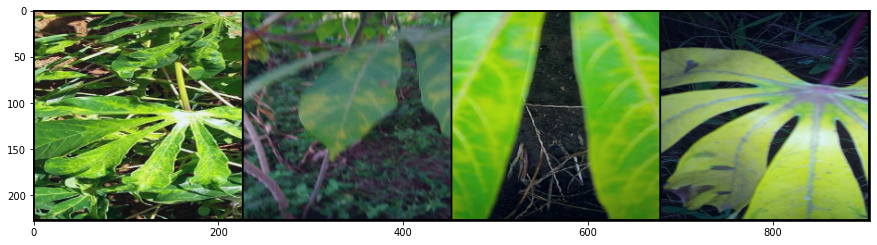

<IPython.core.display.Javascript object>

In [ ]:
train_augs = A.Compose(
    [
        A.RandomResizedCrop(224, 224, p=1.0),
        A.RandomBrightness(limit=0.1),
        A.HueSaturationValue(20, 20, 20),
        A.HorizontalFlip(),
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
    ]
)

valid_augs = A.Compose(
    [A.Resize(224, 224, p=1.0), A.Normalize(p=1.0), ToTensorV2(p=1.0)]
)

csv = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
ims = "../../Datasets/cassava/train_images/"
dm = CassavaLightningDataModule(
    csv,
    ims,
    curr_fold=0,
    train_augs=train_augs,
    valid_augs=valid_augs,
    bs=32,
    num_workers=0,
)
dm.prepare_data()
dm.setup()
train_dl, valid_dl, test_dl = (
    dm.train_dataloader(),
    dm.val_dataloader(),
    dm.test_dataloader(),
)
make_show_grid(train_dl)

In [ ]:
# export
def fetch_scheduler(optim, conf: DictConfig, litm: pl.LightningModule) -> Dict:
    "instantiates an `scheduler` for `optim` from `conf`"
    steps = len(litm.train_dataloader()) // litm.trainer.accumulate_grad_batches

    if conf.scheduler.function._target_ == "torch.optim.lr_scheduler.OneCycleLR":
        lrs = litm.lr_list
        lr_list = [lrs.encoder_lr, lrs.fc_lr]
        kwargs = dict(optimizer=optim, max_lr=lr_list, steps_per_epoch=steps)
        sch = instantiate(conf.scheduler.function, **kwargs)

    elif conf.scheduler.function._target_ == "src.opts.FlatCos":
        kwargs = dict(optimizer=optim, steps_per_epoch=steps)
        sch = instantiate(conf.scheduler.function, **kwargs)

    elif conf.scheduler.function._target_ == "src.opts.CosineAnnealingWarmupScheduler":
        kwargs = dict(optimizer=optim, steps_per_epoch=steps)
        sch = instantiate(conf.scheduler.function, **kwargs)

    elif conf.scheduler.function._target_ == "src.opts.LinearSchedulerWithWarmup":
        kwargs = dict(optimizer=optim, steps_per_epoch=steps, warmup_steps=steps)
        sch = instantiate(conf.scheduler.function, **kwargs)
    else:
        sch = instantiate(conf.scheduler.function, optimizer=opt)

    # convert scheduler to lightning format
    sch = {
        "scheduler": sch,
        "monitor": conf.scheduler.metric_to_track,
        "interval": conf.scheduler.scheduler_interval,
        "frequency": 1,
    }

    return sch

<IPython.core.display.Javascript object>

In [ ]:
# export
# TODO: add midlevel classification branch in learning.
class LightningCassava(pl.LightningModule):
    """LightningModule wrapper for `TransferLearningModel`"""

    def __init__(self, model, conf: DictConfig):
        super().__init__()

        # set up init args
        self.save_hyperparameters(conf)
        self.model = model
        self.accuracy = pl.metrics.Accuracy()

        if isinstance(self.model, VisionTransformer):
            self._log.warning("Use class src.lightning.core.LightningVisionTransformer")

        try:
            mixmethod = instantiate(self.hparams["mixmethod"])
        except:
            mixmethod = None

        if mixmethod is not None:
            if isinstance(mixmethod, SnapMix):
                assert isinstance(self.model, SnapMixTransferLearningModel)

        self.mix_fn = mixmethod
        self.loss_func = instantiate(self.hparams["loss"])
        self.val_labels_list = []
        self.val_preds_list = []
        self.one_batch = None

    def forward(self, xb):
        "forward meth"
        return self.model(xb)

    def training_step(self, batch, batch_idx):
        "training step for one-batch"
        x, y = batch

        if self.mix_fn is not None:
            x = self.mix_fn(x, y, self.model)
            y_hat = self(x)
            loss = self.mix_fn.loss(self.loss_func, y_hat)

        else:
            y_hat = self(x)
            loss = self.loss_func(y_hat, y)

        self.one_batch = x

        train_acc = self.accuracy(y_hat, y)

        self.log("train/loss", loss, on_epoch=True)
        self.log("train/acc", train_acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        "Validation step for one-batch"
        x, y = batch
        y_hat = self(x)
        loss = self.loss_func(y_hat, y)
        acc = self.accuracy(y_hat, y)

        # For confusion matrix purposes
        preds = torch.argmax(y_hat, 1)
        val_labels = y.data.cpu().numpy()
        val_preds = preds.data.cpu().numpy()

        self.val_preds_list = self.val_preds_list + list(val_preds)
        self.val_labels_list = self.val_labels_list + list(val_labels)

        metrics = {"valid/loss": loss, "valid/acc": acc}

        self.log_dict(metrics)

    def test_step(self, batch, batch_idx):
        "test step for one-batch"
        x, y = batch
        y_hat = self(x)

        loss = self.loss_func(y_hat, y)
        acc = self.accuracy(y_hat, y)

        metrics = {"test/loss": loss, "test/acc": acc}
        self.log_dict(metrics)

    def configure_optimizers(self):
        param_list = [
            {"params": self.param_list[0], "lr": self.lr_list.encoder_lr},
            {"params": self.param_list[1], "lr": self.lr_list.fc_lr},
        ]

        opt = instantiate(self.hparams.optimizer, params=param_list)
        sch = fetch_scheduler(opt, self.hparams, self)
        return [opt], [sch]

    @property
    def lr_list(self) -> namedtuple:
        "returns lrs for encoder and fc of the model"
        lrs = namedtuple("Lrs", ["encoder_lr", "fc_lr"])
        encoder_lr = self.hparams.learning_rate / self.hparams.lr_mult
        fc_lr = self.hparams.learning_rate
        return lrs(encoder_lr, fc_lr)

    @property
    def param_list(self) -> List:
        "returns the list of parameters [params of encoder, params of fc]"
        param_list = [params(self.model.encoder), params(self.model.fc)]
        return param_list

    def load_state_from_checkpoint(self, path: str):
        "loads in the weights of the LightningModule from given checkpoint"
        self._log.info(f"Attempting to load checkpoint {os.path.relpath(path)}")
        checkpoint = torch.load(path, map_location=self.device)
        self._log.info(f"Successfully loaded checkpoint {os.path.relpath(path)}")

        self.load_state_dict(checkpoint["state_dict"])
        self._log.info(f"Successfully loaded weights from checkpoint {path}")

    def save_model_weights(self, path: str):
        "saves weights of self.model"
        self._log.info(f"Attempting to save weights to {os.path.relpath(path)}")
        state = self.model.state_dict()
        torch.save(state, path)
        self._log.info(f"Successfully saved weights to {os.path.relpath(path)}")

    def load_model_weights(self, path: str):
        "loads weights of self.model"
        self._log.info(f"Attempting to load weights from {os.path.relpath(path)}")
        state_dict = torch.load(path)
        self.model.load_state_dict(state_dict)
        self._log.info(f"Successfully loaded weights from {os.path.relpath(path)}")

<IPython.core.display.Javascript object>

In [ ]:
model_hparams = dict(
    mixmethod=dict(_target_="src.mixmethods.SnapMix", alpha=5.0, conf_prob=1.0),
    loss=dict(_target_="src.losses.LabelSmoothingCrossEntropy", eps=0.1),
    learning_rate=1e-03,
    lr_mult=100,
    optimizer=dict(
        _target_="torch.optim.AdamW", weight_decay=1e-02, betas=[0.95, 0.999], eps=1e-05
    ),
    scheduler=dict(
        function=dict(_target_="torch.optim.lr_scheduler.OneCycleLR", epochs=10,),
        metric_to_track=None,
        scheduler_interval="step",
    ),
)

cfg = OmegaConf.create(model_hparams)

<IPython.core.display.Javascript object>

In [ ]:
def train_dataloader(self):
    return train_dl


LightningCassava.train_dataloader = train_dataloader

encoder = timm.create_model("resnet18", pretrained=False)

model = SnapMixTransferLearningModel(encoder, cut=-2, c=5)

model = LightningCassava(model=model, conf=cfg)
trainer = pl.Trainer()
model.trainer = trainer

opt_list, lr_scheduler_list = model.configure_optimizers()
opt, lr_scheduler = opt_list[0], lr_scheduler_list[0]["scheduler"]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


<IPython.core.display.Javascript object>

In [ ]:
# export
# @TODO: Add Snapmix support
class LightningVisionTransformer(pl.LightningModule):
    """LightningModule wrapper for `VisionTransfer`"""

    def __init__(self, model: VisionTransformer, conf: DictConfig = None):
        super().__init__()
        self.save_hyperparameters(conf)
        self.model = model
        self.accuracy = pl.metrics.Accuracy()

        try:
            mixmethod = instantiate(self.hparams["mixmethod"])
        except:
            mixmethod = None

        if mixmethod is not None:
            assert not isinstance(
                mixmethod, SnapMix
            ), "Snapmix not supported in Vision Transformer"

        self.mix_fn = mixmethod
        self.loss_func = instantiate(self.hparams["loss"])
        self.val_labels_list = []
        self.val_preds_list = []
        self.one_batch = None

    def forward(self, xb):
        return self.model(xb)

    def training_step(self, batch, batch_idx):
        x, y = batch

        if self.mix_fn is not None:
            x = self.mix_fn(x, y, self.model)
            y_hat = self(x)
            loss = self.mix_fn.loss(self.loss_func, y_hat)

        else:
            y_hat = self(x)
            loss = self.loss_func(y_hat, y)

        self.one_batch = x

        train_acc = self.accuracy(y_hat, y)

        self.log("train/loss", loss, on_epoch=True)
        self.log("train/acc", train_acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_func(y_hat, y)
        acc = self.accuracy(y_hat, y)

        # For confusion matrix purposes
        preds = torch.argmax(y_hat, 1)
        val_labels = y.data.cpu().numpy()
        val_preds = preds.data.cpu().numpy()

        self.val_preds_list = self.val_preds_list + list(val_preds)
        self.val_labels_list = self.val_labels_list + list(val_labels)

        metrics = {"valid/loss": loss, "valid/acc": acc}
        self.log_dict(metrics)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.loss_func(y_hat, y)
        acc = self.accuracy(y_hat, y)

        metrics = {"test/loss": loss, "test/acc": acc}
        self.log_dict(metrics)

    def configure_optimizers(self):
        param_list = [
            {"params": self.param_list[0], "lr": self.lr_list.encoder_lr},
            {"params": self.param_list[1], "lr": self.lr_list.fc_lr},
        ]

        opt = instantiate(self.hparams.optimizer, params=param_list)
        sch = fetch_scheduler(opt, self.hparams, self)
        return [opt], [sch]

    @property
    def lr_list(self) -> namedtuple:
        "returns lrs for encoder and fc of the model"
        lrs = namedtuple("Lrs", ["encoder_lr", "fc_lr"])
        encoder_lr = self.hparams.learning_rate / self.hparams.lr_mult
        fc_lr = self.hparams.learning_rate
        return lrs(encoder_lr, fc_lr)

    @property
    def param_list(self):
        "returns the list of parameters [(params of the model - params of head), params of head]"
        model_params = params(self.model)[:-2]
        head_params = params(self.model.model.head)
        param_list = [model_params, head_params]
        return param_list

    def load_state_from_checkpoint(self, path: str):
        "loads in the weights of the LightningModule from given checkpoint"
        self._log.info(f"Attempting to load checkpoint {os.path.relpath(path)}")
        checkpoint = torch.load(path, map_location=self.device)
        self._log.info(f"Successfully loaded checkpoint {os.path.relpath(path)}")

        self.load_state_dict(checkpoint["state_dict"])
        self._log.info(f"Successfully loaded weights from checkpoint {path}")

    def save_model_weights(self, path: str):
        "saves weights of self.model"
        self._log.info(f"Attempting to save weights to {os.path.relpath(path)}")
        state = self.model.state_dict()
        torch.save(state, path)
        self._log.info(f"Successfully saved weights to {os.path.relpath(path)}")

    def load_model_weights(self, path: str):
        "loads weights of self.model"
        self._log.info(f"Attempting to load weights from {os.path.relpath(path)}")
        state_dict = torch.load(path)
        self.model.load_state_dict(state_dict)
        self._log.info(f"Successfully loaded weights from {os.path.relpath(path)}")

<IPython.core.display.Javascript object>

In [ ]:
model_hparams = dict(
    mixmethod=dict(_target_=None),
    loss=dict(_target_="src.losses.LabelSmoothingCrossEntropy", eps=0.1),
    learning_rate=1e-03,
    lr_mult=100,
    optimizer=dict(
        _target_="torch.optim.AdamW", weight_decay=1e-02, betas=[0.95, 0.999], eps=1e-05
    ),
    scheduler=dict(
        function=dict(
            _target_="src.opts.LinearSchedulerWithWarmup",
            total_epochs=10,
            last_epoch=-1,
        ),
        metric_to_track=None,
        scheduler_interval="step",
    ),
)

cfg = OmegaConf.create(model_hparams)

<IPython.core.display.Javascript object>

In [ ]:
def train_dataloader(self):
    return train_dl


LightningVisionTransformer.train_dataloader = train_dataloader

encoder = timm.create_model("vit_base_patch16_224", pretrained=True)
model = VisionTransformer(encoder=encoder, c=5)
lit_model = LightningVisionTransformer(model, cfg)

trainer = pl.Trainer()
lit_model.trainer = trainer

opt_list, lr_scheduler_list = lit_model.configure_optimizers()
opt, lr_scheduler = opt_list[0], lr_scheduler_list[0]["scheduler"]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


<IPython.core.display.Javascript object>

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_mixmethods.ipynb.
Converted 02_losses.ipynb.
Converted 03_layers.ipynb.
Converted 03a_networks.ipynb.
Converted 04_optimizers_schedules.ipynb.
Converted 05_lightning.core.ipynb.
Converted 05a_lightning.callbacks.ipynb.
Converted 06_fastai.core.ipynb.
Converted index.ipynb.


<IPython.core.display.Javascript object>